In [5]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, multilabel_confusion_matrix
from sklearn.metrics import auc, roc_curve, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.utils.class_weight import compute_class_weight
from sklearn.linear_model import LogisticRegression, LinearRegression, Ridge
from sklearn.svm import SVC, LinearSVC
from sklearn.preprocessing import scale, label_binarize
from sklearn.calibration import CalibratedClassifierCV

In [6]:
import pandas as pd  # provides interface for interacting with tabular data
import geopandas as gpd  # combines the capabilities of pandas and shapely for geospatial operations
from shapely.geometry import Point, Polygon, MultiPolygon  # for manipulating text data into geospatial shapes
from shapely import wkt  # stands for "well known text," allows for interchange across GIS programs
import rtree  # supports geospatial join
import os
import fnmatch
import numpy as np
import matplotlib.pyplot as plt
import descartes
import sys
import sklearn
from shapely.ops import nearest_points
from datetime import datetime as dt, date
sys.path.append('C:/Users/jades/1001 Intro to Data Science Notebooks/Project/wildfires-1001/code/functions/')
from gis_processing import *
import pickle

In [7]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

# Combine Final Multi Class Predictions with Cost Function and Plot Them

In [8]:
## Create cost matrix
## Create formula to calculate cost by grid by month
## Merge on geometry
## Average cost by grid or just take results from 2019??
## Plot

In [9]:
git_dir = 'C:/Users/jades/1001 Intro to Data Science Notebooks/Project/wildfires-1001/'

In [10]:
# Import renaming dictionary and feature list
weather_rename_dict = pd.read_pickle(os.path.join(git_dir, 'data/clean_data/ERA_weather-data/ERA_rename_dictionary.pkl'))
feat_list = pd.read_pickle(os.path.join(git_dir, 'models/feature_lists/RF_entropy_top30_features.pkl'))

# Import overall dataframe with county, grid, pop density etc.
target_df1 = pd.read_pickle(os.path.join(git_dir, 'data/clean_data/target_df_final_1123_newtargets_1.pkl'))
target_df2 = pd.read_pickle(os.path.join(git_dir, 'data/clean_data/target_df_final_1123_newtargets_2.pkl'))
target_df = target_df1.append(target_df2)
target_df.rename(columns = weather_rename_dict, inplace = True)

# Import model and feature list for the model
mod_mc = pd.read_pickle(os.path.join(git_dir, 'models/Ensemble_LR_30entropy+preds_ph2.pkl'))
X_df = pd.read_pickle(os.path.join(git_dir, 'code/model_dev/MultiClass_DF_Ph3.pkl'))

#Import grid data
county_grid_map = gpd.read_file(os.path.join(git_dir, 'data/clean_data/county_grid/county_grid.shp'))
county_grid_map = county_grid_map.to_crs(crs='epsg:4326')

# Generate the cost matrix
cost_matrix = [[0,-0.25,-2.5,-12.5],[-1,0,-0.225,-0.245],[-10,-0.9,0,-0.05],[-50,-0.98,-0.2,0]]

In [11]:
# Create predictions
#preds = mod_mc.predict(X_df)
preds = mod_mc.predict_proba(X_df)
X_df['preds_proba_size0'] = preds[:, 0]
X_df['preds_proba_size1'] = preds[:, 1]
X_df['preds_proba_size2'] = preds[:, 2]
X_df['preds_proba_size3'] = preds[:, 3]

In [12]:
# Create a dataframe to hold our cost values (2016-2019)
cost_df = target_df.merge(X_df, how='inner', left_index=True, right_index=True)[['GRID_ID', 'month_id', 'MONTH', 'COUNTYFP', 'COUNTY_AREA', 'POPDENSITY', 'Y_fire_class_size', 'preds_proba_size0', 'preds_proba_size1', 'preds_proba_size2', 'preds_proba_size3']]

In [13]:
# Apply the cost matrix to calculate the cost of each prediction
conditions = [
    (cost_df.Y_fire_class_size == 0),
    (cost_df.Y_fire_class_size == 1),
    (cost_df.Y_fire_class_size == 2),
    (cost_df.Y_fire_class_size == 3)
    ]

# For each actual size, determine the cost of our prediction class by multiplying the cost by the probability by the pop density
values = [(cost_df['preds_proba_size0']*cost_matrix[0][0] + cost_df['preds_proba_size1']*cost_matrix[0][1] + cost_df['preds_proba_size2']*cost_matrix[0][2] + cost_df['preds_proba_size3']*cost_matrix[0][3]) * np.log(cost_df['POPDENSITY']), 
          (cost_df['preds_proba_size0']*cost_matrix[1][0] + cost_df['preds_proba_size1']*cost_matrix[1][1] + cost_df['preds_proba_size2']*cost_matrix[1][2] + cost_df['preds_proba_size3']*cost_matrix[1][3]) * np.log(cost_df['POPDENSITY']),
          (cost_df['preds_proba_size0']*cost_matrix[2][0] + cost_df['preds_proba_size1']*cost_matrix[2][1] + cost_df['preds_proba_size2']*cost_matrix[2][2] + cost_df['preds_proba_size3']*cost_matrix[2][3]) * np.log(cost_df['POPDENSITY']),
          (cost_df['preds_proba_size0']*cost_matrix[3][0] + cost_df['preds_proba_size1']*cost_matrix[3][1] + cost_df['preds_proba_size2']*cost_matrix[3][2] + cost_df['preds_proba_size3']*cost_matrix[3][3]) * np.log(cost_df['POPDENSITY'])]

# Create a new column and use np.select to assign values to it using our lists as arguments
cost_df['cost'] = np.select(conditions, values)

# Create a new cost column that is positive instead of negative
cost_df['cost_flipped'] = -cost_df['cost']

In [14]:
# Aggreate cost by grid
# Average cost

#cost_by_grid = cost_df[['GRID_ID','cost_flipped']].groupby('GRID_ID').mean().reset_index()
#cost_by_grid = cost_df[(cost_df['MONTH'] >= 5) & (cost_df['MONTH'] <= 10)][['GRID_ID','cost_flipped']].groupby('GRID_ID').mean().reset_index()
cost_by_grid = cost_df[(cost_df['MONTH'] < 5) | (cost_df['MONTH'] > 10)][['GRID_ID','cost_flipped']].groupby('GRID_ID').mean().reset_index()

In [15]:
# Add costs to the geometries dataframe
county_cost_plot = county_grid_map.merge(cost_by_grid, 'inner', left_on='GRID_ID', right_on='GRID_ID')

Text(0.5, 1.0, 'Misclassification Cost 2016-2019 by Grid')

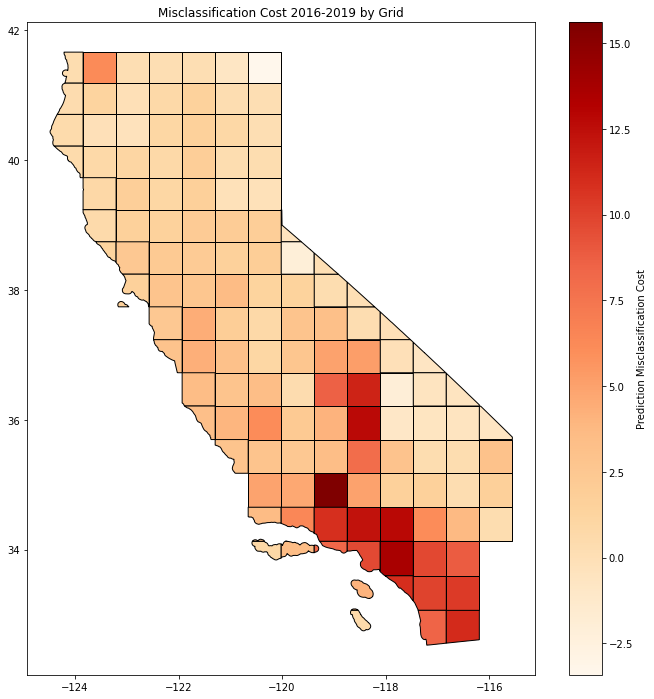

In [16]:
# Plot costs
ax = county_cost_plot.plot(edgecolor = 'black', figsize = (12,12), column='cost_flipped'
                     , legend='reverse', legend_kwds={'label': "Prediction Misclassification Cost"}, cmap='OrRd')

plt.title('Misclassification Cost 2016-2019 by Grid')